In [1]:
import numpy as onp
import jax.numpy as np
from jax import random
from jax import jit
from jax_md.util import *
import matplotlib.pyplot as plt
key = random.PRNGKey(0)
from jax_md import quantity

from jax_pd import space, materials, damage, mesh, plots, solvers, util


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lib/xla_bridge.py:115: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [20]:
displacement_fn, shift_fn = space.free()

R = np.array([[i,j,k] for i in range(10) for j in range(3) for k in range(3)],dtype=np.float32)

bonds, lengths = util.bonds_n_lengths(R,cutoff=f32(2))

energy_fn = [materials.simple_spring_bond(displacement_fn, bond=bonds, length=lengths, epsilon=100, stretch=0.1)]


In [21]:
def move(R,bool,t=0,R0=R,v=np.array([[0.01,0,0]])):
    return R0[bool,:]+t*v

def fix(R,bool,t=0,R0=R):
    return R0[bool,:]


Rbc = [{'bool':R[:,0]<2.5,'fn':move,'kwargs':{'R0':R,'v':np.array([[0,-0.001,0]])}},
       {'bool':R[:,0]>6.5,'fn':move,'kwargs':{'R0':R,'v':np.array([[0,0.001,0]])}},
              ]

# Rbc = []

# iVbc = [{'bool':R[:,0]>7.5,'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,1]])}},
#        {'bool':(R[:,0]>2.5) & (R[:,0]<6.5),'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,-1]])}},
#        {'bool':R[:,0]<1.5,'fn':fix,'kwargs':{'R0':R*0-np.array([[0,0,1]])}},
#        ]


/Users/ravinderbhattoo/anaconda3/lib/python3.7/site-packages/jax/lax/lax.py:4547: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


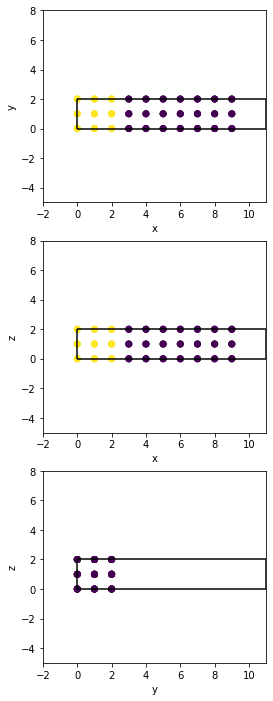

In [22]:
R1 = [R]

def Plotit(i):
    x,y = 1,3
    fig, axs = plt.subplots(y,x,figsize=[4*x,4*y])
    labels = [['x','y'],['x','z'],['y','z']]
    for ax,label in zip(axs,labels):
        ax.set_xlim([-2, 11])
        ax.set_ylim([-5, 8])
        ax.hlines(0,0,11)
        ax.hlines(2,0,11)
        ax.vlines(0,0,2)
        ax.vlines(11,0,2)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.axis('on')

    plots.W3(i,R1,axs,c=(Rbc[0]['bool']).astype(int))
    plt.show()

Plotit(0)


In [23]:
R1 = [R]
runs = 5000
R2, state_values, state = solvers.run_simulation(key,runs,1.0e-3, R,energy_fn,shift_fn,Rbc=Rbc,mass=1.0,print_every=500,value_every=3,pos_every=1)

R1 += R2

Initial conditions(after iBC): 
KE: 0.000000, PE: 0.000, TE: 0.000
Initial conditions(after BC): 
KE: 0.000000, PE: 0.000, TE: 0.000
KE: 0.000000, PE: 0.000, TE: 0.000
KE: 1203.783813, PE: 62.889, TE: 1266.673
KE: 8745.600586, PE: 84.858, TE: 8830.459
KE: 15373.696289, PE: 57.706, TE: 15431.402
KE: 17530.716797, PE: 62.364, TE: 17593.080
KE: 17467.675781, PE: 21.764, TE: 17489.439
KE: 14492.675781, PE: 19.182, TE: 14511.857
KE: 12639.872070, PE: 26.024, TE: 12665.896
KE: 11362.892578, PE: 25.002, TE: 11387.895
KE: 10433.864258, PE: 27.528, TE: 10461.393
KE: 9741.784180, PE: 29.716, TE: 9771.500


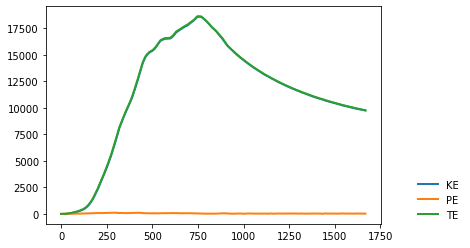

In [24]:
plt.plot(range(len(state_values)),np.array(state_values),lw=2)
plt.legend(['KE','PE','TE'],frameon=False,loc=[1.1,0])

In [27]:
from jax_md import quantity
force = [quantity.canonicalize_force(i, quantity.Energy) for i in energy_fn]

F1 = []
F2 = []
mask1 = Rbc[0]['bool']
mask2 = Rbc[1]['bool']

for i in range(100):
    F1 += [sum([f(R1[i],t=i*50) for f in force])[mask1,1].sum()]
    F2 += [sum([f(R1[i],t=i*50) for f in force])[mask2,1].sum()]
    

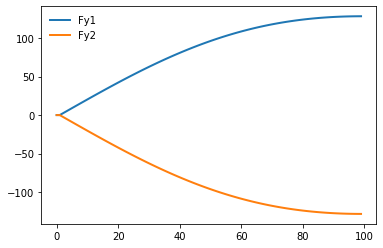

In [29]:
plt.plot(range(len(F1)),F1,label='Fy1',lw=2)
plt.plot(range(len(F2)),F2,label='Fy2',lw=2)
plt.legend(frameon=0)

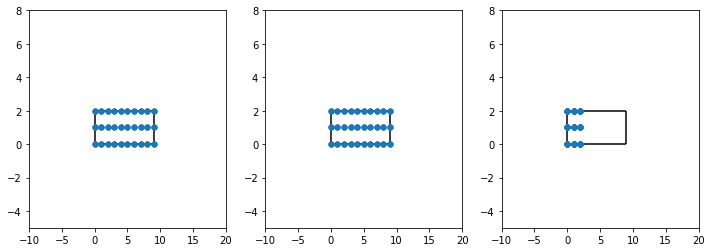

In [25]:
from IPython.display import display

import matplotlib
k = 100
ms = 5


def myplot(i):
    global ax,l,k
    i = i*k
    R_plt = onp.array(R1[i])
    ls[0].set_data(R_plt[:, 0], R_plt[:, 1],) 
    ls[1].set_data(R_plt[:, 0], R_plt[:, 2],) 
    ls[2].set_data(R_plt[:, 1], R_plt[:, 2],) 


fig, axs = plt.subplots(1,3,figsize=[12,4])
ls = []
for ax in axs:
    ls.append(ax.plot([],[],'o', markersize=ms)[0])
    ax.set_xlim([-10, 20])
    ax.set_ylim([-5, 8])
    ax.hlines(0,0,9)
    ax.hlines(2,0,9)
    ax.vlines(0,0,2)
    ax.vlines(9,0,2)
    ax.axis('on')


from matplotlib.animation import FuncAnimation
ani = FuncAnimation(fig, myplot, frames=int(len(R1)/k))

from IPython.display import HTML
_ = HTML(ani.to_jshtml())


In [26]:
display(_)